In [ ]:
# Instalasi library yang diperlukan
!pip install tensorflow matplotlib ipython
!pip install kaggle
!pip install --upgrade tensorflow
!pip install --upgrade keras

from google.colab import files
import os
import shutil

# Menghapus file kaggle.json jika sudah ada
if os.path.exists('kaggle.json'):
    os.remove('kaggle.json')

# Upload file kaggle.json
files.upload()  # Upload 'kaggle.json'

# Menghapus direktori ~/.kaggle jika sudah ada
kaggle_dir = os.path.expanduser('~/.kaggle')
if os.path.exists(kaggle_dir):
    shutil.rmtree(kaggle_dir)

# Membuat direktori untuk kaggle dan menyalin kaggle.json
os.makedirs(kaggle_dir, exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Menghapus dataset jika sudah ada
dataset_zip = 'coffee-leaf-diseases.zip'
if os.path.exists(dataset_zip):
    os.remove(dataset_zip)

# Mengunduh dataset
!kaggle datasets download -d gauravduttakiit/coffee-leaf-diseases

# Menghapus direktori dataset jika sudah ada
dataset_dir = './coffee-leaf-diseases'

if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)

# Men-unzip dataset
!unzip coffee-leaf-diseases.zip -d ./coffee-leaf-diseases

# Menelusuri dataset
for subdir, dirs, files in os.walk(dataset_dir):
    print(f"Subdirectory: {subdir}")
    for file in files:
        print(f" - {file}")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/coffee-leaf-diseases
License(s): CC0-1.0
 94% 171M/181M [00:00<00:00, 198MB/s]
100% 181M/181M [00:00<00:00, 214MB/s]
Archive:  coffee-leaf-diseases.zip
  inflating: ./coffee-leaf-diseases/test.csv  
  inflating: ./coffee-leaf-diseases/test/miner/1100.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1101.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1102.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1103.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1104.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1105.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1106.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1107.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1108.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1109.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1110.jpg  
  inflating: ./coffee-leaf-diseases/test/miner/1111.jpg  
  inflatin

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZEx = 256
IMAGE_SIZEy=256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./coffee-leaf-diseases/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEx,IMAGE_SIZEy),
    batch_size=BATCH_SIZE
)

Found 1264 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['miner', 'nodisease', 'phoma', 'rust']

In [ ]:
len(dataset)

40

In [ ]:
train_size = 0.8
len(dataset)*train_size

32.0

In [ ]:
train_ds = dataset.take(13)
len(train_ds)

13

In [ ]:
test_ds = dataset.skip(13)
len(test_ds)

27

In [ ]:
val_size=0.1
len(dataset)*val_size

4.0

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

26

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

32

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

4

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import models, layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZEx, IMAGE_SIZEy),
    layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
CHANNELS = 3

input_shape = (BATCH_SIZE, IMAGE_SIZEx, IMAGE_SIZEy, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 776ms/step - accuracy: 0.2483 - loss: 1.3798 - val_accuracy: 0.3125 - val_loss: 1.3661
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step - accuracy: 0.3098 - loss: 1.3647 - val_accuracy: 0.3359 - val_loss: 1.3521
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.3452 - loss: 1.3381 - val_accuracy: 0.3359 - val_loss: 1.2883
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.4329 - loss: 1.1752 - val_accuracy: 0.4453 - val_loss: 1.1953
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.4917 - loss: 1.1114 - val_accuracy: 0.5625 - val_loss: 1.0272
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.6031 - loss: 1.0148 - val_accuracy: 0.5625 - val_loss: 1.0046
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.6856 - loss: 0.7761 - val_accuracy: 0.6250 - val_loss: 0.7076
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.7211 - loss: 0.6914 - val_accu

In [ ]:
scores = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9917 - loss: 0.0425


In [ ]:
scores

[0.04553694650530815, 0.9921875]

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 32}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['accuracy'])

35

In [ ]:
history.history['val_accuracy']

[0.3125,
 0.3359375,
 0.3359375,
 0.4453125,
 0.5625,
 0.5625,
 0.625,
 0.7890625,
 0.71875,
 0.8203125,
 0.8203125,
 0.875,
 0.875,
 0.90625,
 0.875,
 0.9375,
 0.9375,
 0.9375,
 0.9296875,
 0.9375,
 0.9453125,
 0.953125,
 0.9375,
 0.9296875,
 0.9765625,
 0.921875,
 0.9453125,
 0.9609375,
 0.859375,
 0.96875,
 0.9140625,
 0.953125,
 0.9765625,
 0.9765625,
 0.9375]

In [ ]:
history.history['loss'][:5]

[1.3790602684020996,
 1.3633983135223389,
 1.2983237504959106,
 1.1582155227661133,
 1.083193302154541]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

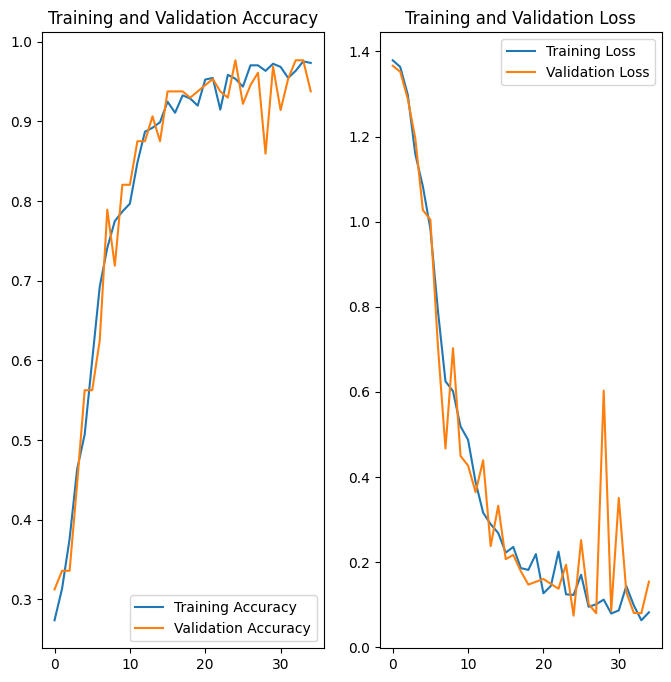

In [ ]:
# Dapatkan panjang data yang sebenarnya
history_length = len(acc)  # atau len(loss)

plt.figure(figsize=(8, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(history_length), acc, label='Training Accuracy')
plt.plot(range(history_length), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(history_length), loss, label='Training Loss')
plt.plot(range(history_length), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: phoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted label: phoma
first image to predict
actual label: nodisease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted label: nodisease


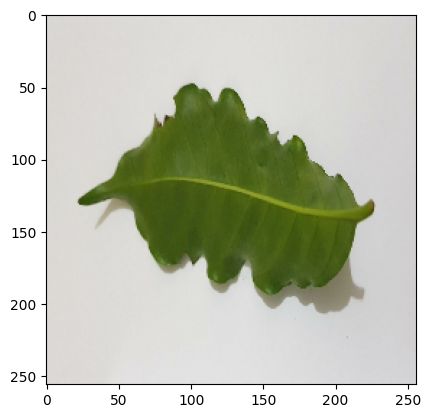

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


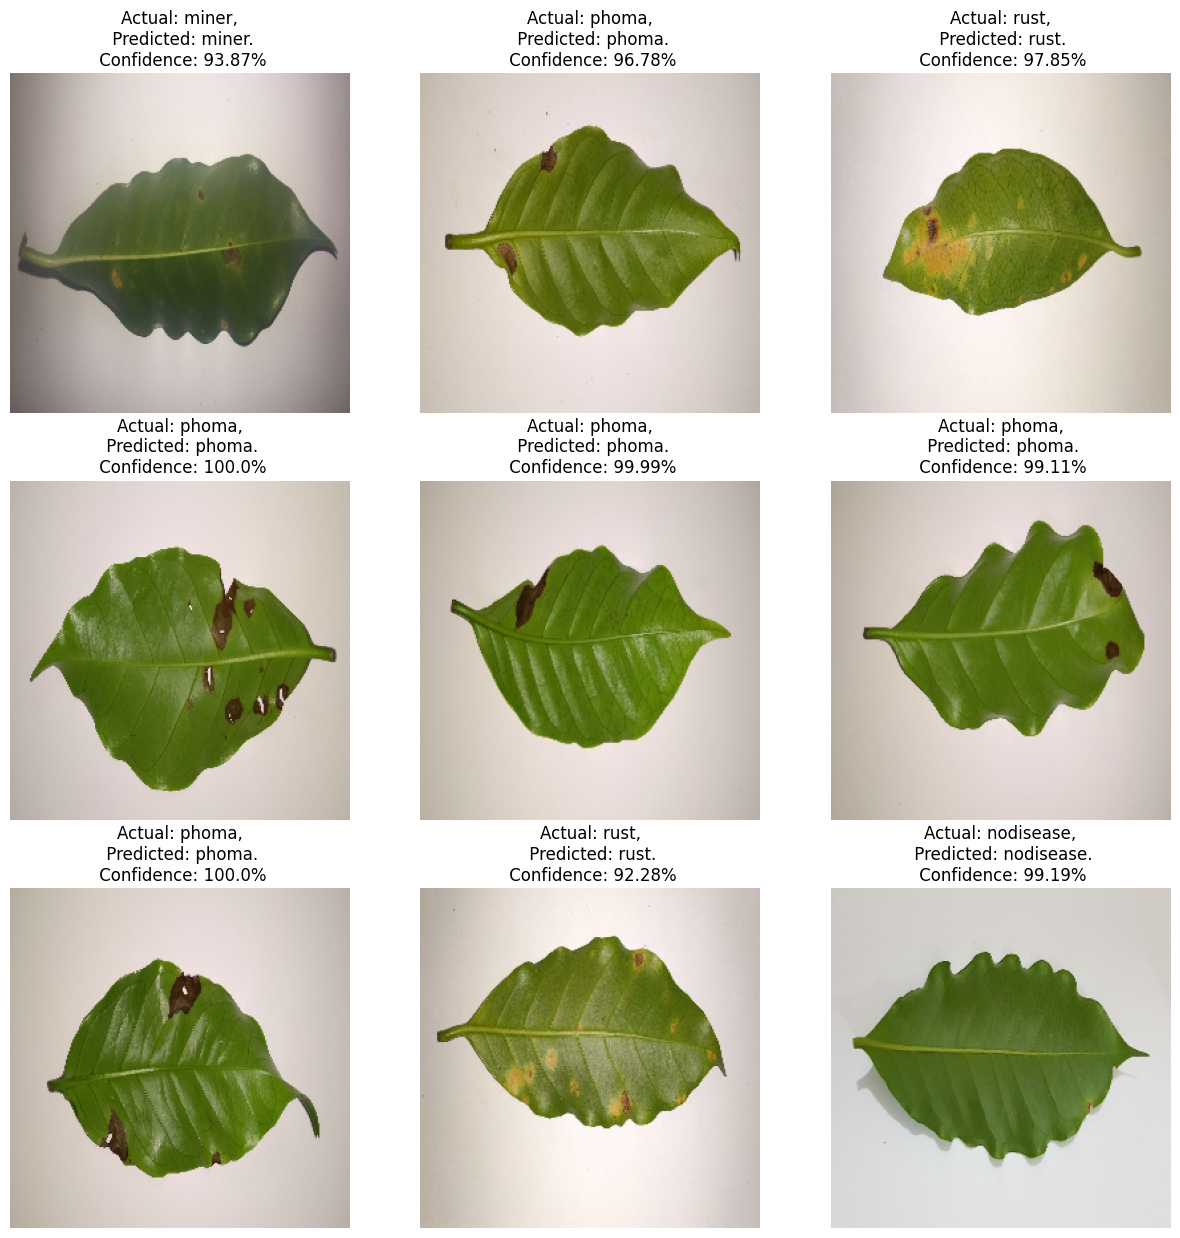

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model_version = 20
model.save("./working/model_{}.h5".format(model_version))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


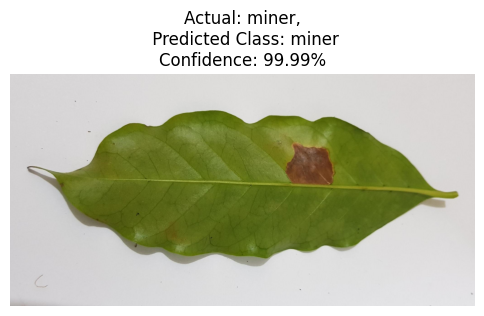

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


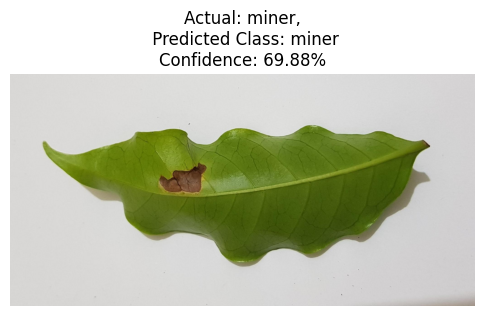

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


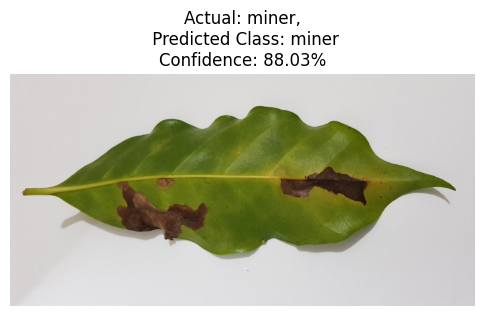

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


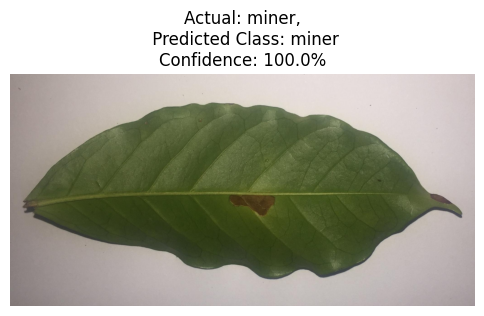

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


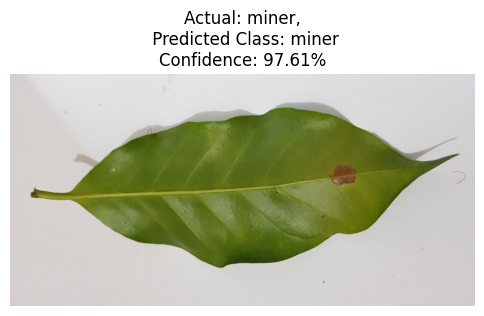

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


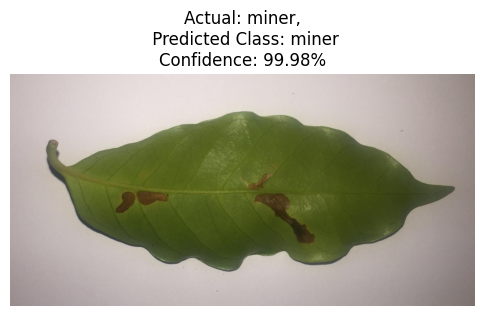

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


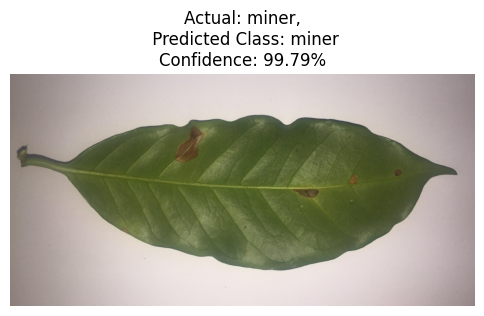

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


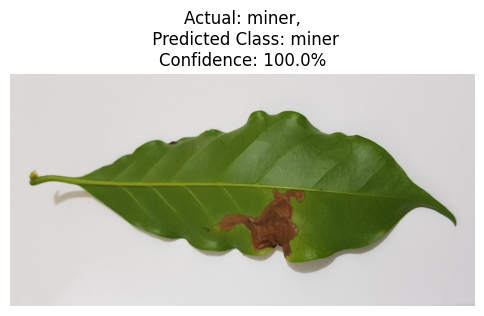

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


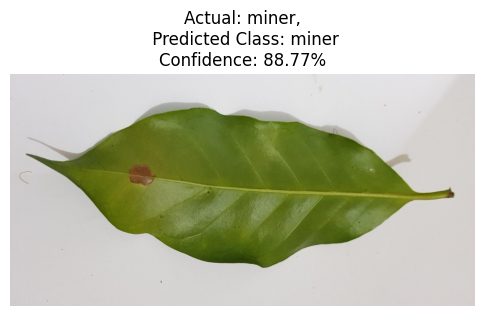

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


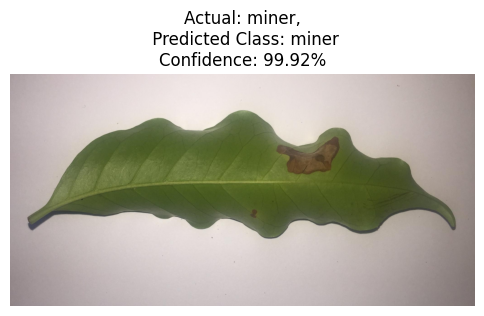

In [ ]:
#testing the model

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


model = tf.keras.models.load_model(r"./working/model_20.h5")


class_names = ['miner', 'nodisease', 'phoma', 'rust']


miner ="./coffee-leaf-diseases/test/miner"
nodisease= "./coffee-leaf-diseases/test/nodisease"
phoma="./coffee-leaf-diseases/test/phoma"
rust="./coffee-leaf-diseases/test/rust"
max_iterations=10
def classificator(image_dirteste,actual_class,max_iterations):

    iteration_count = 0
    image_dirteste = image_dirteste
    for filename in os.listdir(image_dirteste):

            if filename.endswith('.jpg'):

                image_path = os.path.join(image_dirteste, filename)


                predicted_class, confidence = predict(model, image_path, class_names)
                Actual: {actual_class}

                plt.figure(figsize=(6, 6))
                img = plt.imread(image_path)
                plt.imshow(img)
                plt.title(f"Actual: {actual_class},\n Predicted Class: {predicted_class}\nConfidence: {confidence}%")
                plt.axis('off')
                plt.show()

                iteration_count += 1


            if iteration_count >= max_iterations:
                break

classificator(miner,'miner',10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


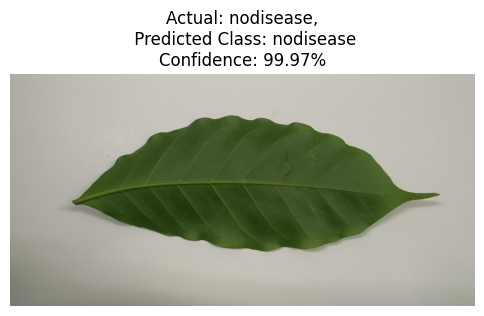

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


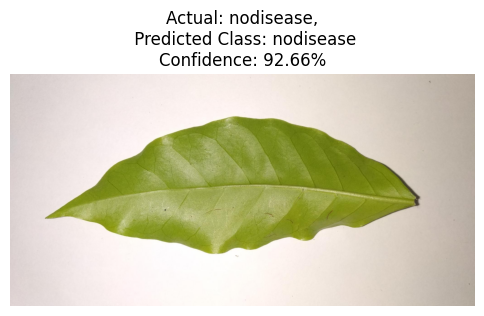

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


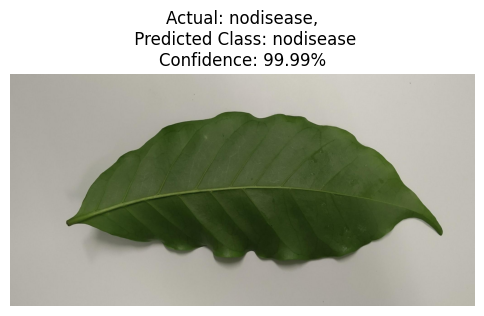

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


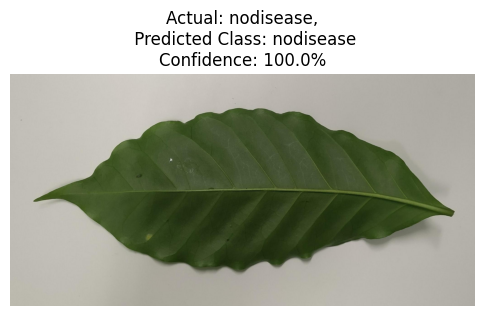

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


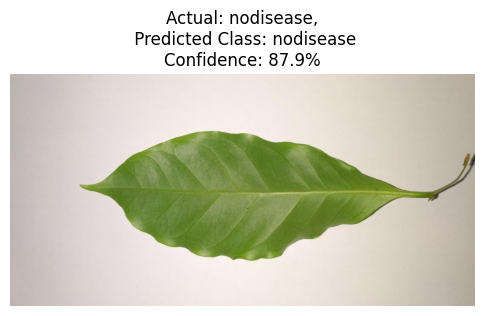

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


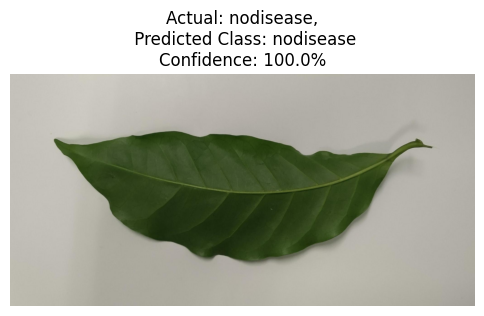

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


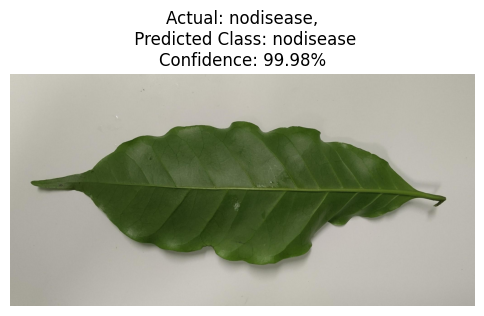

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


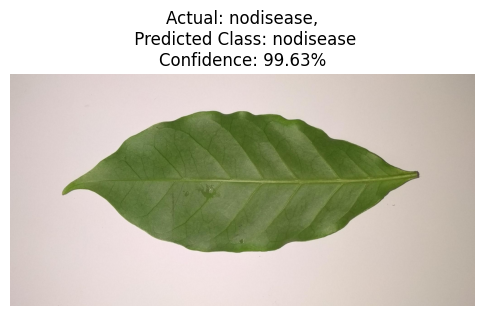

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


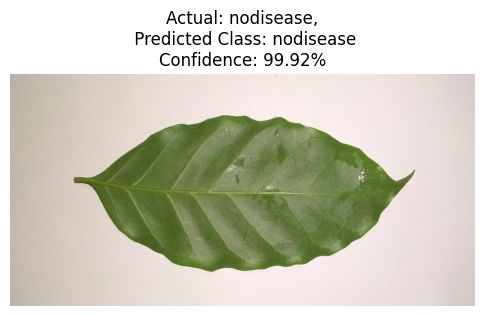

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


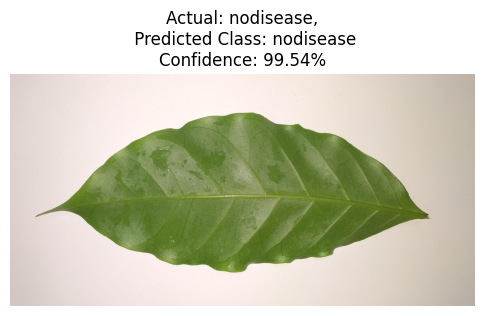

In [ ]:
classificator(nodisease,'nodisease',10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


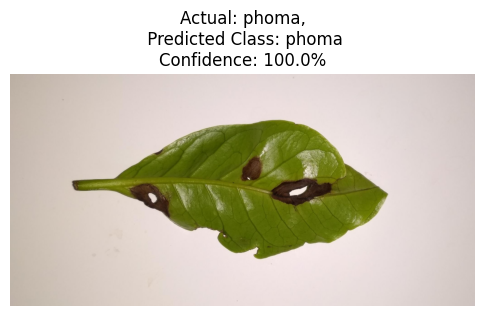

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


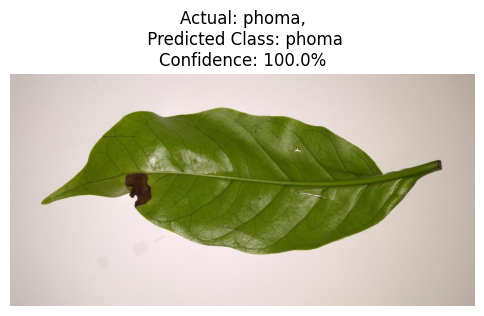

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


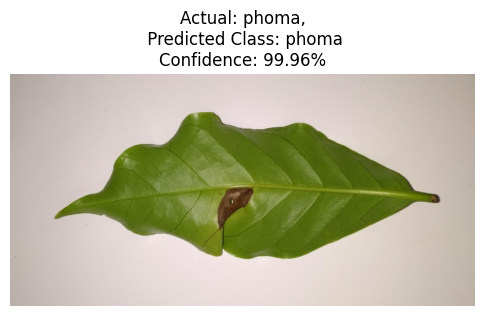

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


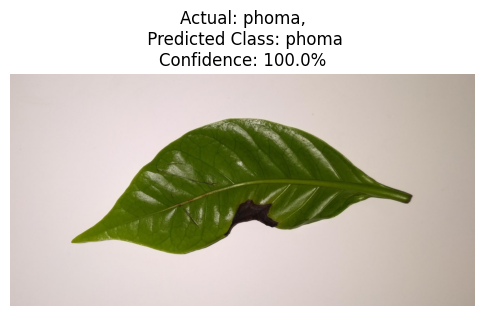

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


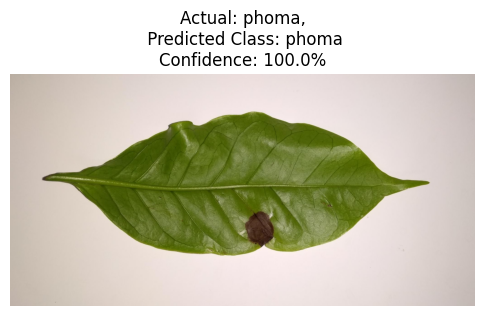

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


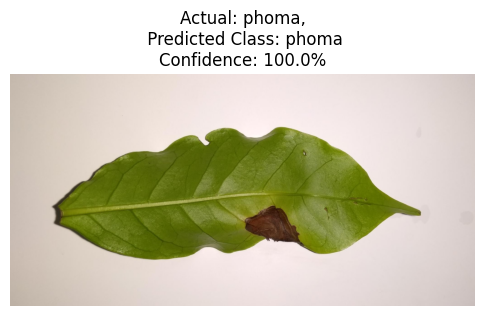

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


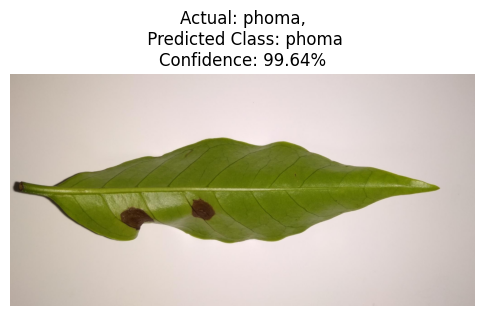

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


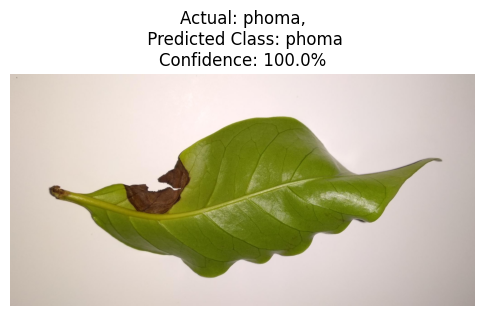

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


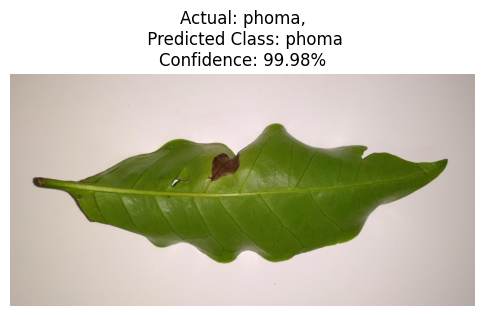

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


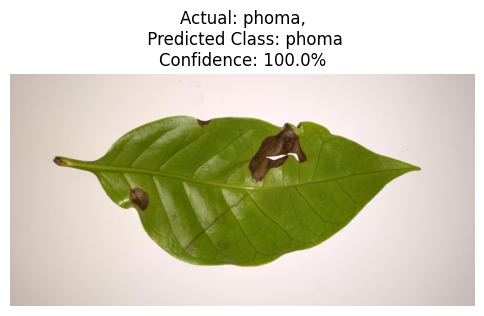

In [ ]:
classificator(phoma,'phoma',10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


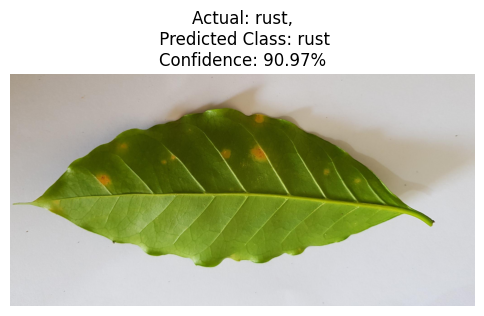

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


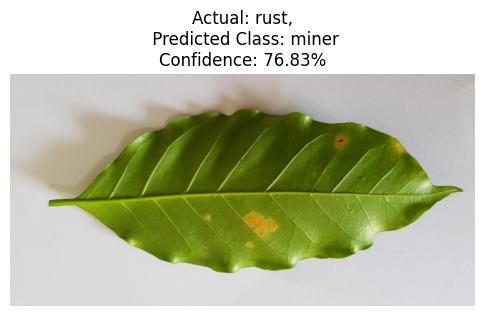

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


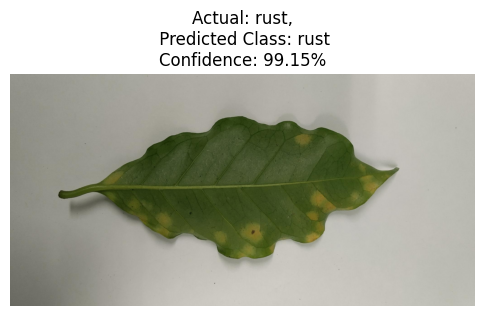

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


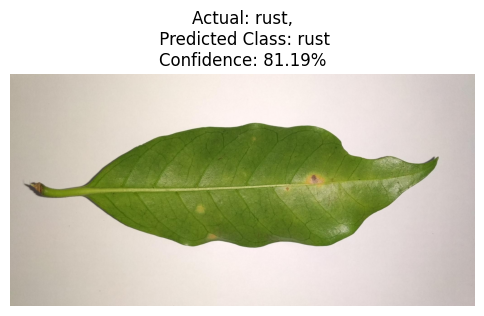

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


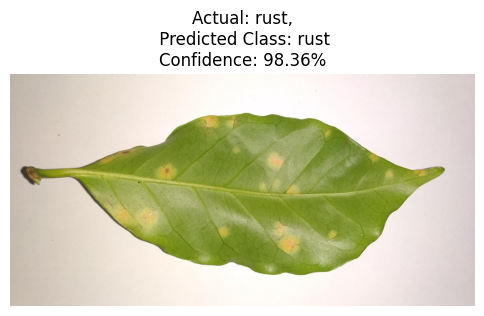

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


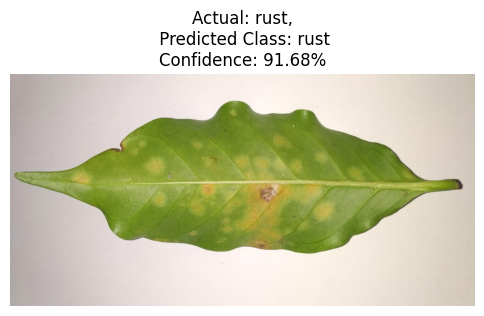

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


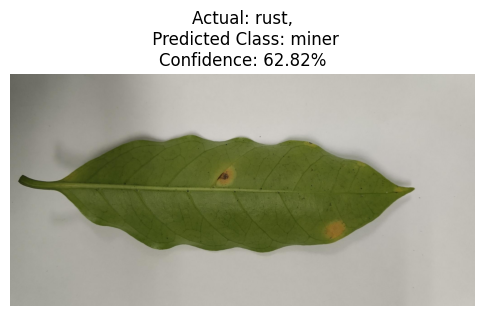

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


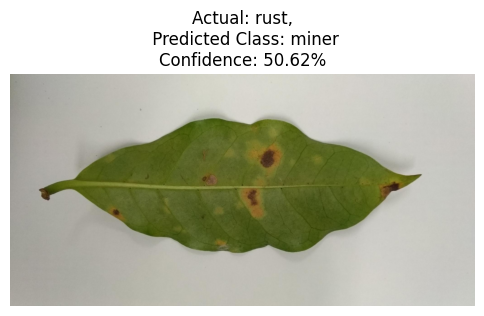

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


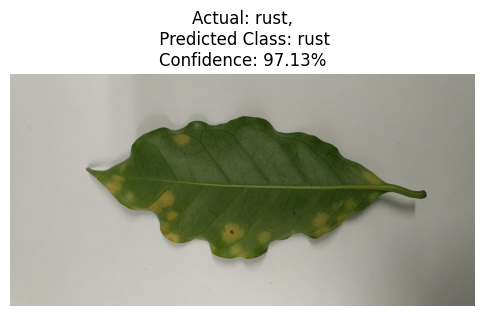

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


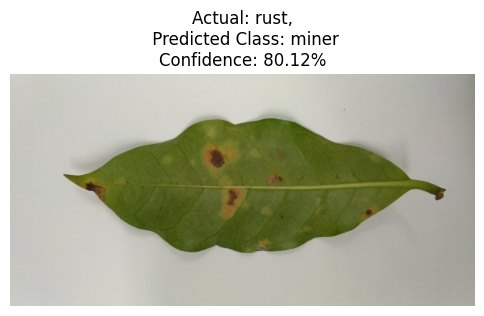

In [ ]:
classificator(rust,'rust',10)